In [ ]:
function ConnectButton(){
    console.log("Connect pushed");
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
}
setInterval(ConnectButton,60000);

In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import load_model

In [ ]:
IMGS = np.load('/content/drive/MyDrive/YANG/npy/0615/imgs.npy')
RATIO = np.load('/content/drive/MyDrive/YANG/npy/0615/ratios.npy')
TARGET = np.load('/content/drive/MyDrive/YANG/npy/0615/target.npy')

print("IMGS shape:", IMGS.shape)
print("RATIO shape:", RATIO.shape)
print("TARGET shape:", TARGET.shape)

IMGS shape: (36196, 224, 224, 3)
RATIO shape: (36196,)
TARGET shape: (36196, 5)
TARGET_int shape: (36196,)


In [ ]:
# 데이터 수
n_samples = IMGS.shape[0]

# 데이터 인덱스 배열 만들기
indices = np.arange(n_samples)

# 인덱스 배열 섞기
np.random.shuffle(indices)

# 섞인 인덱스로 데이터 섞기
IMGS_shuffled = IMGS[indices]
RATIO_shuffled = RATIO[indices]
TARGET_shuffled = TARGET[indices]

print("IMGS_shuffled shape:", IMGS_shuffled.shape)
print("RATIO_shuffled shape:", RATIO_shuffled.shape)
print("TARGET_shuffled shape:", TARGET_shuffled.shape)

IMGS_shuffled shape: (36196, 224, 224, 3)
RATIO_shuffled shape: (36196,)
TARGET_shuffled shape: (36196, 5)


In [ ]:
import gc
del IMGS
del RATIO
del TARGET
gc.collect()

87

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 클래스 수 정의
num_classes = 5

# 이미지 입력 정의
image_input = Input(shape=(224, 224, 3))

# 사전 학습된 ResNet152V2 모델 로드 (최상위 레이어 제외)
base_model = ResNet152V2(weights='imagenet', include_top=False, input_tensor=image_input)

# GlobalAveragePooling2D 레이어 추가
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)

# 추가 입력(상수) 정의
additional_input = Input(shape=(1,))

# 추가 입력을 기존 레이어와 결합
x = Concatenate()([x, additional_input])

# Fully Connected Layer 추가
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(num_classes, activation='softmax')(x)

# 모델 정의
model = Model(inputs=[image_input, additional_input], outputs=output)

# 일부 층은 훈련되지 않도록 설정 (동결)
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model.compile(optimizer='adam', # sgd, Nadam, Adagrad
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

234545216/234545216 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                           

In [ ]:
# 옵션 지정
os.makedirs(f"/content/drive/MyDrive/YANG/model/final_model/just_sh", exist_ok=True)

#early_stopping은 val_loss를 기준으로 멈추게, checkpoint는 val_acc기준으로 업데이트 되게끔 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    "/content/drive/MyDrive/YANG/model/final_model/just_sh/model_{val_accuracy:.2f}_{val_loss:.2f}.keras",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='auto')

In [ ]:
history = model.fit([IMGS_shuffled, RATIO_shuffled], TARGET_shuffled, validation_split=0.2, epochs=100, batch_size=16, verbose=1, callbacks=[checkpoint, early_stopping])

Epoch 1/100
1810/1810 [==============================] - ETA: 0s - loss: 1.1783 - accuracy: 0.4784
Epoch 1: val_accuracy improved from -inf to 0.60815, saving model to /content/drive/MyDrive/YANG/model/final_model/just_sh/model_0.61_0.93.keras
1810/1810 [==============================] - 97s 47ms/step - loss: 1.1783 - accuracy: 0.4784 - val_loss: 0.9288 - val_accuracy: 0.6081
Epoch 2/100
1810/1810 [==============================] - ETA: 0s - loss: 0.9240 - accuracy: 0.5885
Epoch 2: val_accuracy improved from 0.60815 to 0.67017, saving model to /content/drive/MyDrive/YANG/model/final_model/just_sh/model_0.67_0.78.keras
1810/1810 [==============================] - 75s 41ms/step - loss: 0.9240 - accuracy: 0.5885 - val_loss: 0.7796 - val_accuracy: 0.6702
Epoch 3/100
1810/1810 [==============================] - ETA: 0s - loss: 0.8317 - accuracy: 0.6325
Epoch 3: val_accuracy improved from 0.67017 to 0.68343, saving model to /content/drive/MyDrive/YANG/model/final_model/just_sh/model_0.68_0.7

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_history(history):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # 손실을 위한 축
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(history.history['loss'], label='Train Loss', color='tab:red')
    ax1.plot(history.history['val_loss'], label='Val Loss', color='tab:orange')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax1.legend(loc='upper left')

    # 정확도를 위한 축
    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax2.plot(history.history['accuracy'], label='Train Accuracy', color='tab:blue')
    ax2.plot(history.history['val_accuracy'], label='Val Accuracy', color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    ax2.legend(loc='upper right')

    fig.tight_layout()
    plt.title('Training and Validation Loss and Accuracy')
    plt.show()

In [ ]:
# 학습 결과 그래프로 시각화
def plot_history_loss(history):
    # 요약된 손실 그래프
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='train loss',color='tab:red')
    plt.plot(history.history['val_loss'], label='val loss',color='tab:orange')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

def plot_history_acc(history):

    # 요약된 정확도 그래프
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='train accuracy',color='tab:blue')
    plt.plot(history.history['val_accuracy'], label='val accuracy',color='tab:green')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()



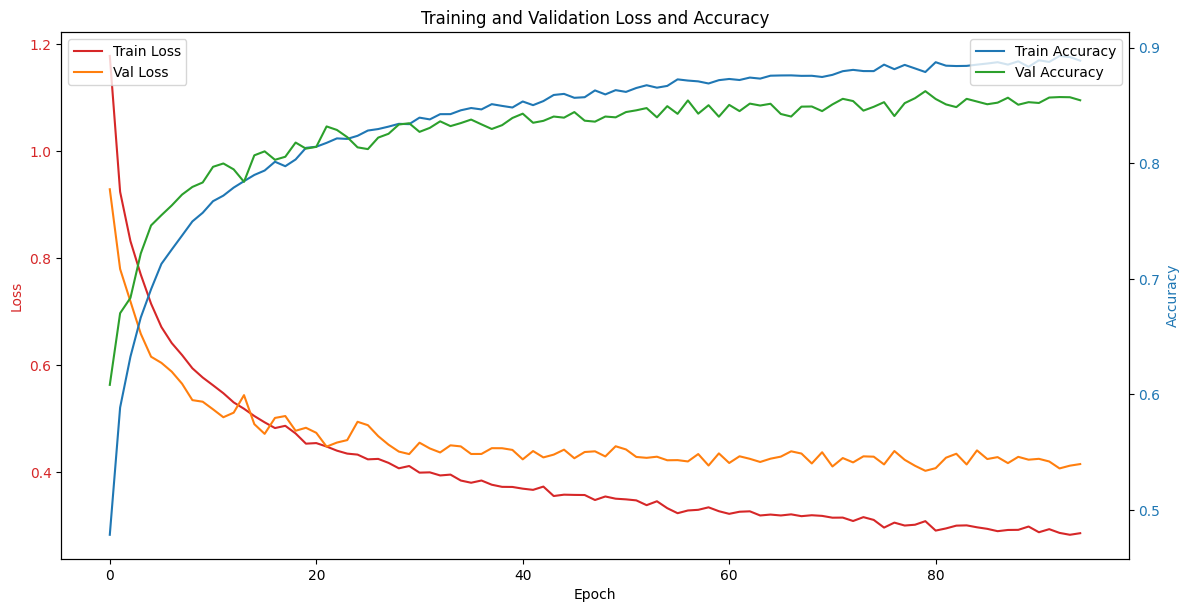

In [ ]:
plot_history(history)

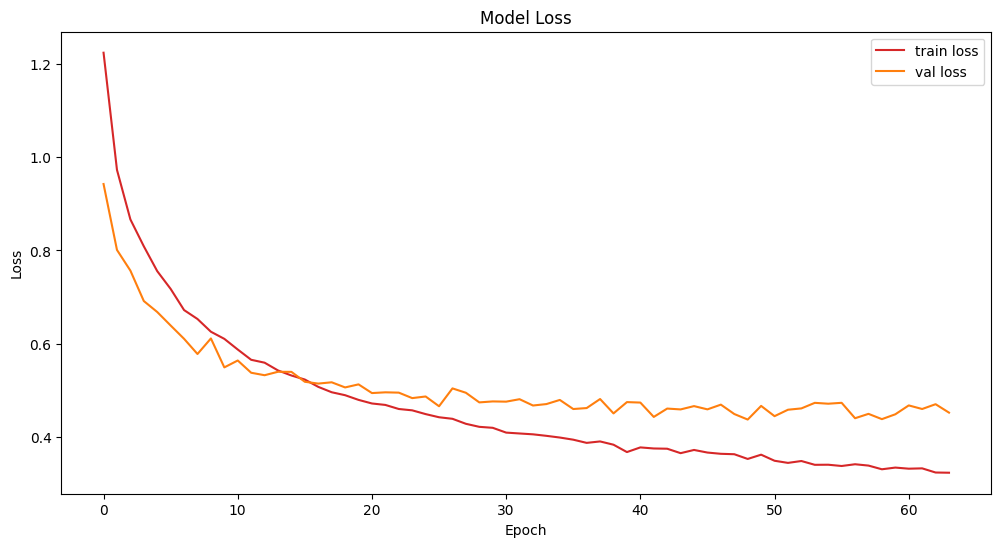

In [ ]:
plot_history_loss(history)

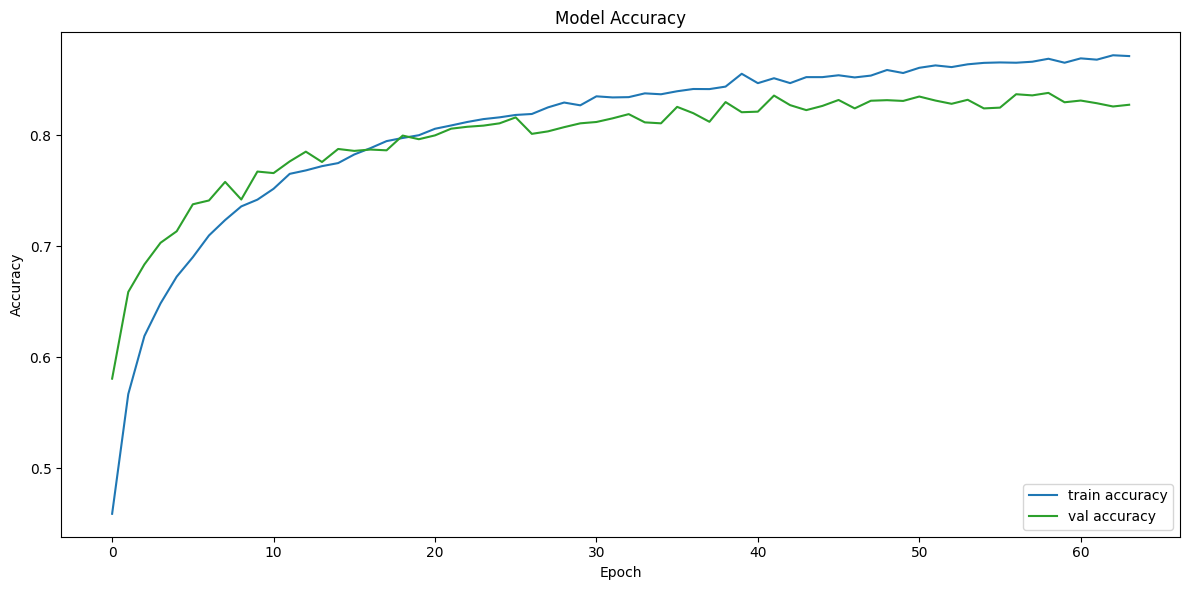

In [ ]:
plot_history_acc(history)